# Proyecto 01 - Parte 02
**Caso aplicativo**
El estudio “CineVision Studios” está complacido con lo que descubrió en el análisis exploratorio que su equipo le entregó. Sin embargo, le han surgido nuevas interrogantes. En la conformación de su equipo de Data Science, uno de los candidatos, en las entrevistas le ha comentado que existen algoritmos que permiten detectar patrones no evidentes en los datos que le proporcionó y “juntar” variables para que
sea más pequeño. Le ha pedido que indague un poco más en los datos y extraiga información interesante.

## Procesamiento

### Ingesta de datos

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pyclustertend

file_path = "./movies.csv"
df = pd.read_csv(file_path, encoding="latin1")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   budget                     10000 non-null  int64  
 2   genres                     9947 non-null   object 
 3   homePage                   4193 non-null   object 
 4   productionCompany          9543 non-null   object 
 5   productionCompanyCountry   8720 non-null   object 
 6   productionCountry          9767 non-null   object 
 7   revenue                    10000 non-null  float64
 8   runtime                    10000 non-null  int64  
 9   video                      9514 non-null   object 
 10  director                   9926 non-null   object 
 11  actors                     9920 non-null   object 
 12  actorsPopularity           9913 non-null   object 
 13  actorsCharacter            9953 non-null   obje

### Normalización de datos

In [46]:
columns_with_pipes = [
    "genres", "productionCompany", "productionCompanyCountry", 
    "productionCountry", "actors", "actorsPopularity", "actorsCharacter"
]

for col in columns_with_pipes:
    df[col + "_count"] = df[col].fillna("").astype(str).apply(lambda x: len(x.split("|")) if x != "" else 0)


df.rename(columns={
    'genres_count': 'genresAmount',
    'productionCompany_count': 'productionCoAmount',
    'productionCountry_count': 'productionCountriesAmount'
}, inplace=True)

df = df.loc[:, ~df.columns.duplicated()]

print("Columnas disponibles:", df.columns.tolist())

Columnas disponibles: ['id', 'budget', 'genres', 'homePage', 'productionCompany', 'productionCompanyCountry', 'productionCountry', 'revenue', 'runtime', 'video', 'director', 'actors', 'actorsPopularity', 'actorsCharacter', 'originalTitle', 'title', 'originalLanguage', 'popularity', 'releaseDate', 'voteAvg', 'voteCount', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount', 'actorsAmount', 'castWomenAmount', 'castMenAmount', 'productionCompanyCountry_count', 'actorsPopularity_count', 'actorsCharacter_count', 'Cluster_Rendimiento_KMeans', 'Cluster_Rendimiento_Agglo', 'Cluster_Financiero_KMeans', 'Cluster_Financiero_Agglo', 'Cluster_Produccion_KMeans', 'Cluster_Produccion_Agglo', 'Cluster_Reparto_KMeans', 'Cluster_Reparto_Agglo', 'actors_count']


### Selección de variables

In [31]:
numeric_columns = ["actorsPopularity", "castWomenAmount", "castMenAmount"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

features = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteCount', 'voteAvg',
    'genresAmount', 'productionCoAmount', 'productionCountriesAmount',
    'actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount'
]

X = df[features].dropna()

scaler_global = StandardScaler()
X_scaled = scaler_global.fit_transform(X)

print("Forma de X_scaled:", X_scaled.shape)

df_scaled = pd.DataFrame(X_scaled, columns=features)
print("Vista previa de los datos globalmente estandarizados:")
print(df_scaled.head())

df_scaled.to_csv("movies_normalized.csv", index=False)

Forma de X_scaled: (39, 13)
Vista previa de los datos globalmente estandarizados:
   popularity    budget   revenue   runtime  voteCount   voteAvg  \
0   -0.481159 -0.175515 -0.162621 -0.601988   3.434166  0.557957   
1   -0.151433 -0.175515 -0.162621 -0.079491   0.173006 -0.591978   
2    0.488561 -0.175515 -0.162621  0.599755   0.410408  0.027217   
3   -0.536668 -0.175515 -0.162621 -0.671654   1.872308 -0.238152   
4   -0.356378 -0.175515 -0.162621 -0.323323  -0.901553  0.734870   

   genresAmount  productionCoAmount  productionCountriesAmount  \
0     -0.535672           -0.495439                  -0.436051   
1      3.642567           -0.495439                  -0.436051   
2     -0.535672            1.574790                   3.343061   
3      1.553448            0.194637                  -0.436051   
4     -0.535672           -0.495439                  -0.436051   

   actorsPopularity  actorsAmount  castWomenAmount  castMenAmount  
0          2.624196      0.426401         1.

In [32]:
# Variables consideradas por análisis como relevantes agruparlas para su estudio
features_rendimiento = ['popularity', 'voteCount', 'voteAvg']
features_financiero  = ['budget', 'revenue']
features_produccion  = ['runtime', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount']
features_reparto     = ['actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount']

def preparar_subconjunto(dataframe, features):
    data = dataframe[features].dropna()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, data.index

data_rendimiento, scaler_rendimiento, indices_rendimiento = preparar_subconjunto(df, features_rendimiento)
data_financiero, scaler_financiero, indices_financiero   = preparar_subconjunto(df, features_financiero)
data_produccion, scaler_produccion, indices_produccion   = preparar_subconjunto(df, features_produccion)
data_reparto, scaler_reparto, indices_reparto             = preparar_subconjunto(df, features_reparto)


## Análsis de la tendencia de agrupamiento

### Estadístico de Hopkins y VAT (Grupo de variables y subgrupos)

#### Global

In [33]:
from sklearn.neighbors import NearestNeighbors

def hopkins(X):
    X = np.array(X)
    n, d = X.shape
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors([rand_X[j]], 2, return_distance=True)
        random_index = np.random.randint(0, n)
        w_dist, _ = nbrs.kneighbors([X[random_index]], 2, return_distance=True)
        ujd.append(u_dist[0][1])
        wjd.append(w_dist[0][1])
    H = np.sum(ujd) / (np.sum(ujd) + np.sum(wjd))
    return H

hopkins_global = hopkins(X_scaled)
print("Hopkins Global:", hopkins_global)


Hopkins Global: 0.7406213908282021


#### Subgrupos (Variables destacadas)

In [34]:
groups = {
    'Rendimiento': data_rendimiento,
    'Financiero': data_financiero,
    'Produccion': data_produccion,
    'Reparto': data_reparto
}

for name, data in groups.items():
    print(f"Hopkins {name}:", hopkins(data))

Hopkins Rendimiento: 0.9957221639614202
Hopkins Financiero: 0.990121006846967
Hopkins Produccion: 0.9960962037592951
Hopkins Reparto: 0.9171550093603467


## Número Óptimo de Clústeres 

### Global

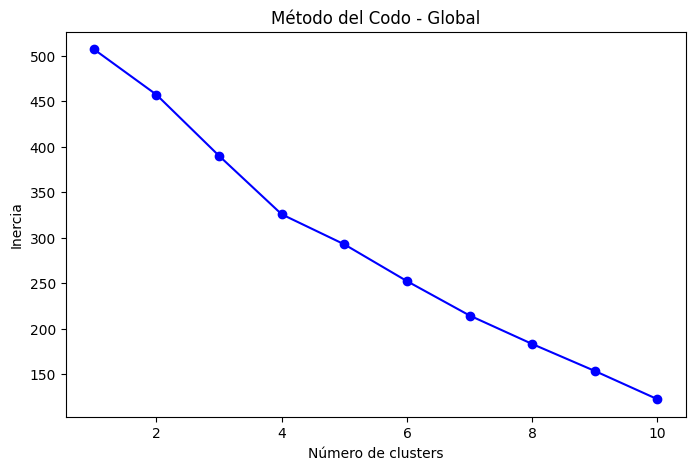

In [35]:
inertia_global = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_global.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia_global, 'bo-')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo - Global")
plt.show()

### Grupos

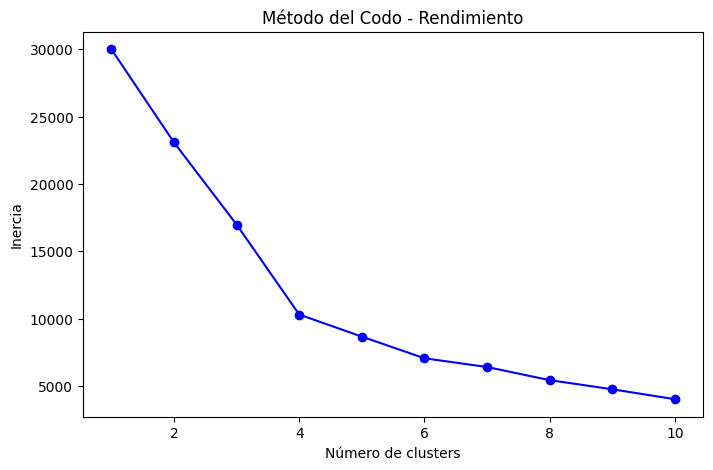

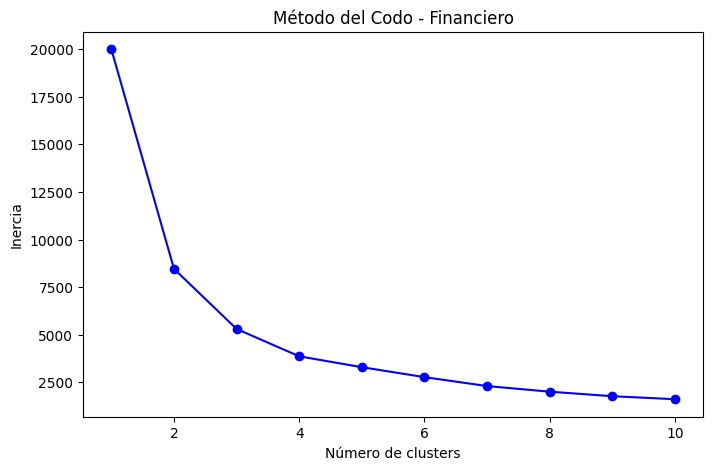

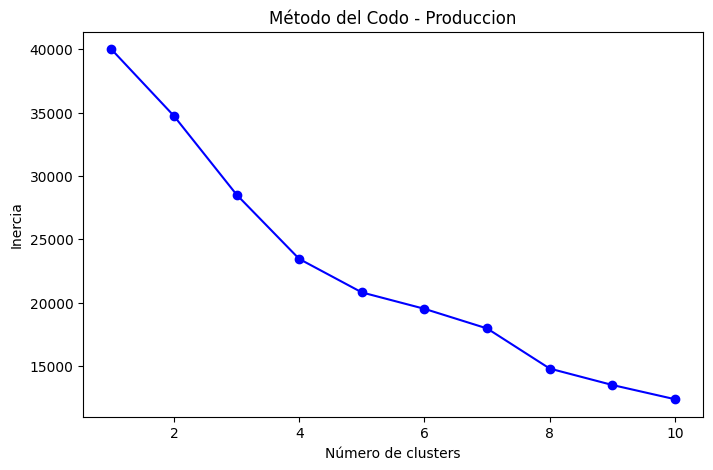

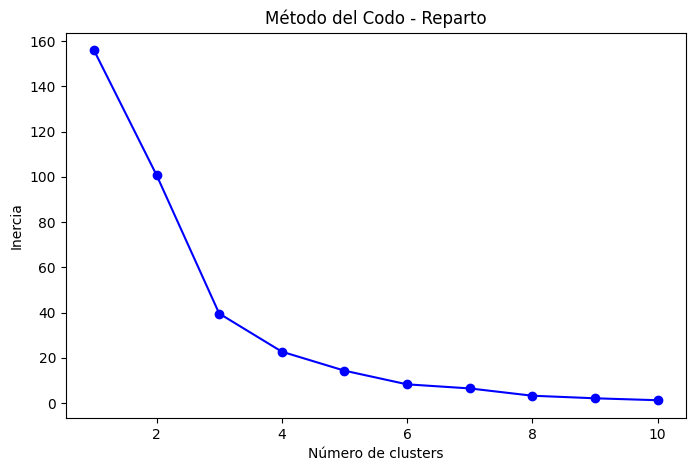

In [36]:
for name, data in groups.items():
    inertia_group = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        inertia_group.append(km.inertia_)
    plt.figure(figsize=(8,5))
    plt.plot(range(1, 11), inertia_group, 'bo-')
    plt.xlabel("Número de clusters")
    plt.ylabel("Inercia")
    plt.title(f"Método del Codo - {name}")
    plt.show()

## Clustering con K-Means y Clustering Jerárquico

### Global

In [48]:
group_optimal = {
    'Rendimiento': 3,
    'Financiero': 2,
    'Produccion': 3,
    'Reparto': 3
}

for name, data in groups.items():
    k = group_optimal[name]
    km = KMeans(n_clusters=k, random_state=42)
    clusters = km.fit_predict(data)
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters_agglo = agglo.fit_predict(data)
    if name == 'Rendimiento':
        idx = indices_rendimiento
    elif name == 'Financiero':
        idx = indices_financiero
    elif name == 'Produccion':
        idx = indices_produccion
    elif name == 'Reparto':
        idx = indices_reparto
    df.loc[idx, f'Cluster_{name}_KMeans'] = clusters
    df.loc[idx, f'Cluster_{name}_Agglo'] = clusters_agglo
    

print(df[['Cluster_Rendimiento_KMeans', 'Cluster_Rendimiento_Agglo',
          'Cluster_Financiero_KMeans', 'Cluster_Financiero_Agglo',
          'Cluster_Produccion_KMeans', 'Cluster_Produccion_Agglo',
          'Cluster_Reparto_KMeans', 'Cluster_Reparto_Agglo']].head(10))

  Cluster_Rendimiento_KMeans Cluster_Rendimiento_Agglo  \
0                          1                         0   
1                          0                         0   
2                          2                         2   
3                          2                         2   
4                          2                         2   
5                          2                         2   
6                          0                         0   
7                          0                         0   
8                          2                         2   
9                          0                         0   

  Cluster_Financiero_KMeans Cluster_Financiero_Agglo  \
0                         1                        1   
1                         1                        1   
2                         0                        0   
3                         0                        0   
4                         0                        0   
5                        